In [27]:
import sys
sys.path.insert(1, '../') 
from utils.loader import Loader
from utils.evaluator import Evaluator

import tensorflow as tf
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, Concatenate, LSTM, Bidirectional, Attention, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import TFAutoModel, AutoTokenizer
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

# Descargar la lista de stopwords si no está ya descargada
nltk.download('stopwords')

# Cargar las stopwords en español
spanish_stopwords = set(stopwords.words('spanish'))


print("¿GPU disponible?:", tf.config.list_physical_devices('GPU'))

¿GPU disponible?: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lingfeng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train = Loader.load_NLP()

/home/lingfeng/Desktop/repos/Cars_Price_Prediction/NLP/../utils/loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
/home/lingfeng/Desktop/repos/Cars_Price_Prediction/NLP/../utils/loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
/home/lingfeng/Desktop/repos/Cars_Price_Prediction/NLP/../utils/loader.py:165: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the origin

In [4]:
def custom_concat(row, cols):
    # Construir la descripción con lógica condicional basada en el valor de la celda
    parts = []
    for col_name in cols:  # Cambio para iterar solo sobre las columnas especificadas
        if col_name in row.index:  # Verificar que el nombre de la columna esté en el DataFrame
            value = row[col_name]
            if value == "no tiene" or not isinstance(value, str):
                parts.append(f"no tiene {col_name}")
            else:
                parts.append(str(value))  # Convertir a string para evitar problemas al unir
    # Unir todas las partes con espacios
    return ' '.join(parts)

# Aplicar la función al DataFrame
def filter_train_data(train):
    descriptions = [col for col in train.columns if "description" in col]
    train['full_description'] = train.apply(custom_concat, axis=1, args=(descriptions,))
    filtered_columns = ["price", "km", "fuelType", "full_description"]
    train = train[filtered_columns]
    train.dropna(inplace=True)
    return train

train = filter_train_data(train)

km_scaler = StandardScaler()
train["km"] = km_scaler.fit_transform(train["km"].to_numpy().reshape(-1, 1))

price_scaler = StandardScaler()
train["price"] = price_scaler.fit_transform(train["price"].to_numpy().reshape(-1, 1))

/tmp/ipykernel_36347/2940014903.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.dropna(inplace=True)
/tmp/ipykernel_36347/2940014903.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["km"] = km_scaler.fit_transform(train["km"].to_numpy().reshape(-1, 1))
/tmp/ipykernel_36347/2940014903.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

In [5]:
#Parameters
verb_size = 150

spanish_model_path = Path("~/resource/w2v/models/complete_vectors.bin").expanduser()
spanish_model_kv = KeyedVectors.load_word2vec_format(str(spanish_model_path), binary=True)

In [6]:
# Load data (assuming df is your DataFrame containing the required columns)
texts = train['full_description'].values  # descriptions
# Tokenization and sequence padding
tokenizer = Tokenizer(num_words=verb_size)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
data = pad_sequences(sequences,  maxlen=verb_size, padding='post')

In [7]:
embedding_matrix = np.zeros((verb_size, spanish_model_kv.vector_size))
for word, i in tokenizer.word_index.items():
    if i < verb_size:
        try:
            embedding_vector = spanish_model_kv[word]  # Get the corresponding vector from Word2Vec model
            embedding_matrix[i] = embedding_vector
        except KeyError:
            # Words not found in the embedding index will be all-zeros.
            continue

In [8]:
train_data, test_data, train_prices, test_prices, train_km, test_km = train_test_split(
    data, train['price'], train['km'], test_size=0.2, random_state=42, stratify=train['fuelType'])

In [9]:
train_data = tf.convert_to_tensor(train_data, dtype=tf.int32)
test_data = tf.convert_to_tensor(test_data, dtype=tf.int32)

I0000 00:00:1730901733.191140   36347 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730901733.191354   36347 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730901733.191438   36347 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730901733.262044   36347 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [10]:
train_prices = tf.convert_to_tensor(train_prices, dtype=tf.float32)
test_prices = tf.convert_to_tensor(test_prices, dtype=tf.float32)

In [11]:
train_km = tf.convert_to_tensor(train_km, dtype=tf.float32)
train_km = tf.convert_to_tensor(train_km, dtype=tf.float32)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")
beto_model = TFAutoModel.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")

RuntimeError: Failed to import transformers.models.bert.modeling_tf_bert because of the following error (look up to see its traceback):
No module named 'transformers.models.bert.modeling_tf_bert'

In [12]:
# Text input branch
text_input = Input(shape=(train_data.shape[1],), dtype='int32')

# Capa de Embedding
text_embed_layer = Embedding(input_dim=train_data.shape[1], 
                             output_dim=spanish_model_kv.vector_size, 
                             input_length=train_data.shape[1],
                             weights=[embedding_matrix],
                             trainable=False)
text_embed = text_embed_layer(text_input)

# Primera capa LSTM bidireccional con 'return_sequences=True' para permitir apilar más capas
lstm_out = Bidirectional(LSTM(128, return_sequences=True))(text_embed)
#lstm_out = Dropout(0.5)(lstm_out)

# Segunda capa LSTM
lstm_out = LSTM(64, return_sequences=True)(lstm_out)
#lstm_out = Dropout(0.5)(lstm_out)

# Capa de Atención
attention_out = Attention()([lstm_out, lstm_out])

# Aplanamos la salida de la atención
flatten = Flatten()(attention_out)

/home/lingfeng/Desktop/tensorflow/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [13]:
# Embedding input branch

# KM branch
input_km = Input(shape=(1,), name='km_input')
km_processed = Dense(32, activation='linear')(input_km)

# Concatenate both branches
concat = Concatenate()([flatten, km_processed])
hidden = Dense(256, activation='relu')(concat)
output = Dense(1, activation='linear')(hidden)  # Output layer for price prediction

model = Model(inputs=[text_input, input_km], outputs=output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 150, 400)  │     60,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 150, 256)  │    541,696 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 150, 64)   │     82,176 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 150, 64)   │          0 │ lstm_1[0][0],     │
│ (Attention)         │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ km_input            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 9600)      │          0 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │         64 │ km_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 9632)      │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │  2,466,048 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        257 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,150,241 (12.02 MB)

 Trainable params: 3,090,241 (11.79 MB)

 Non-trainable params: 60,000 (234.38 KB)

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='huber', metrics=['mean_absolute_error', "mean_absolute_percentage_error"])

In [15]:
# Train the model
print("COMIENZA EL ENTRENAMIENTO...")
history = model.fit([train_data, train_km], train_prices,
          validation_data=([test_data, test_km], test_prices),
          epochs=30, batch_size=128)
print("TERMINA EL ENTRENAMIENTO...")

COMIENZA EL ENTRENAMIENTO...
Epoch 1/30


/home/lingfeng/Desktop/tensorflow/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'km_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(
2024-11-06 15:02:47.542646: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


1033/1033 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1665 - mean_absolute_error: 0.3641 - mean_absolute_percentage_error: 204.3606

/home/lingfeng/Desktop/tensorflow/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'km_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1033/1033 ━━━━━━━━━━━━━━━━━━━━ 59s 54ms/step - loss: 0.1664 - mean_absolute_error: 0.3640 - mean_absolute_percentage_error: 204.3220 - val_loss: 0.0500 - val_mean_absolute_error: 0.1929 - val_mean_absolute_percentage_error: 102.9516
Epoch 2/30
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 56s 54ms/step - loss: 0.0516 - mean_absolute_error: 0.1956 - mean_absolute_percentage_error: 123.4362 - val_loss: 0.0398 - val_mean_absolute_error: 0.1712 - val_mean_absolute_percentage_error: 108.8166
Epoch 3/30
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 56s 54ms/step - loss: 0.0415 - mean_absolute_error: 0.1733 - mean_absolute_percentage_error: 111.3331 - val_loss: 0.0360 - val_mean_absolute_error: 0.1599 - val_mean_absolute_percentage_error: 100.1164
Epoch 4/30
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 56s 54ms/step - loss: 0.0329 - mean_absolute_error: 0.1544 - mean_absolute_percentage_error: 92.5500 - val_loss: 0.0319 - val_mean_absolute_error: 0.1553 - val_mean_absolute_percentage_error: 83.2667
Epoch 5/30
1033/1033 ━━━━━━━━━━━━━━━━

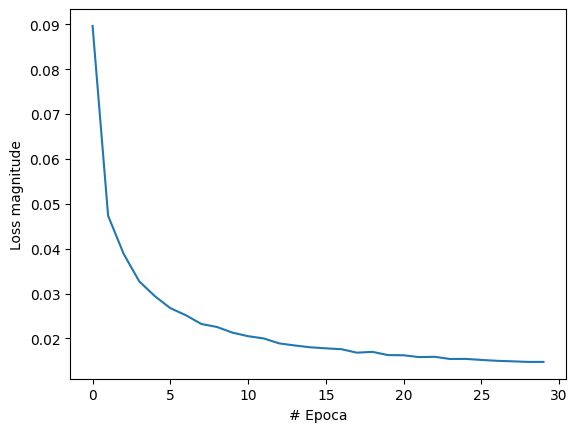

In [16]:
plt.xlabel("# Epoca")
plt.ylabel("Loss magnitude")
plt.plot(history.history["loss"])

1033/1033 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
   Actual_Price  Predicted_Price        km
0  35000.000000     33102.722656  120145.0
1  14400.000000     16144.456055   48873.0
2  27590.000000     31966.232422   60000.0
3  22500.000000     21741.033203      14.0
4   8300.000977     10814.141602  193123.0
MAE: 2508.651 
 MSE: 33075792.0 
 RMSE: 5751.156 
 R2: 0.92778480052948 
 MAPE: 12.353237718343735
Mean: 2508.651
Variance: 26782460.0
Standard Deviation: 5175.1772


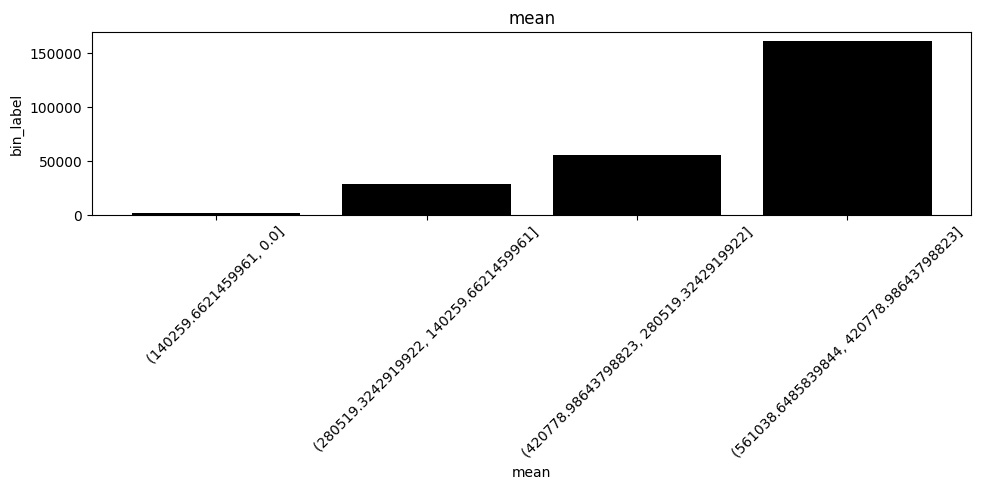

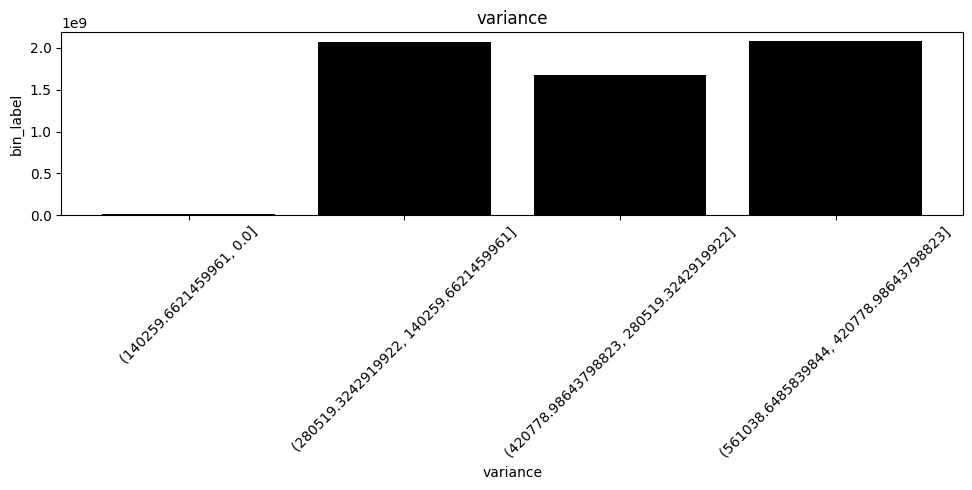

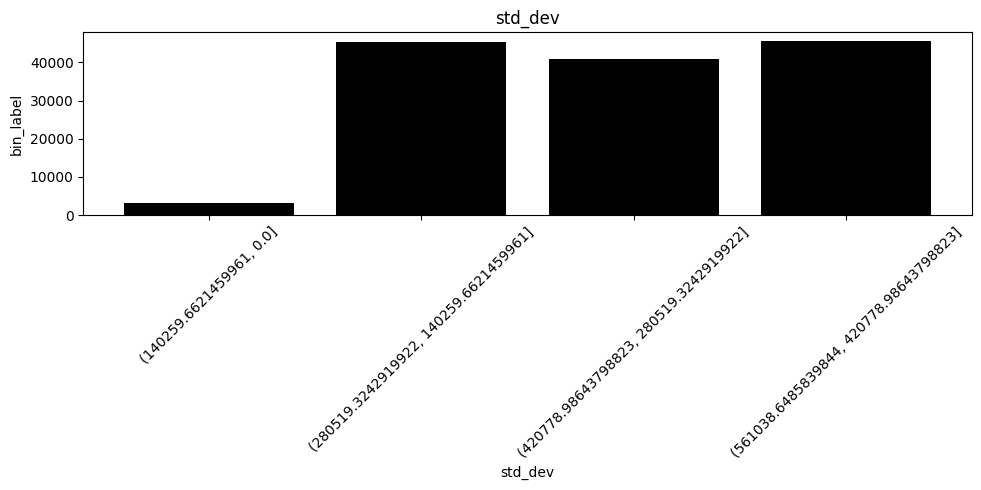

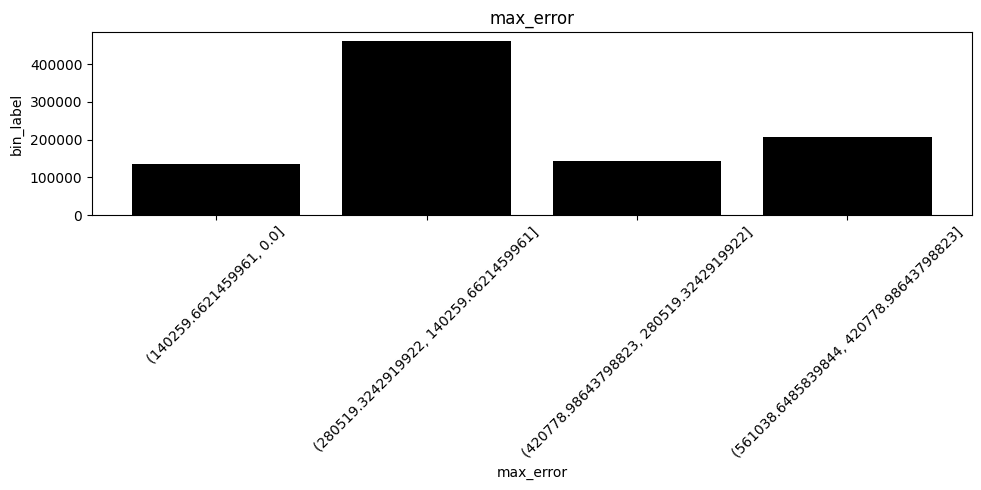

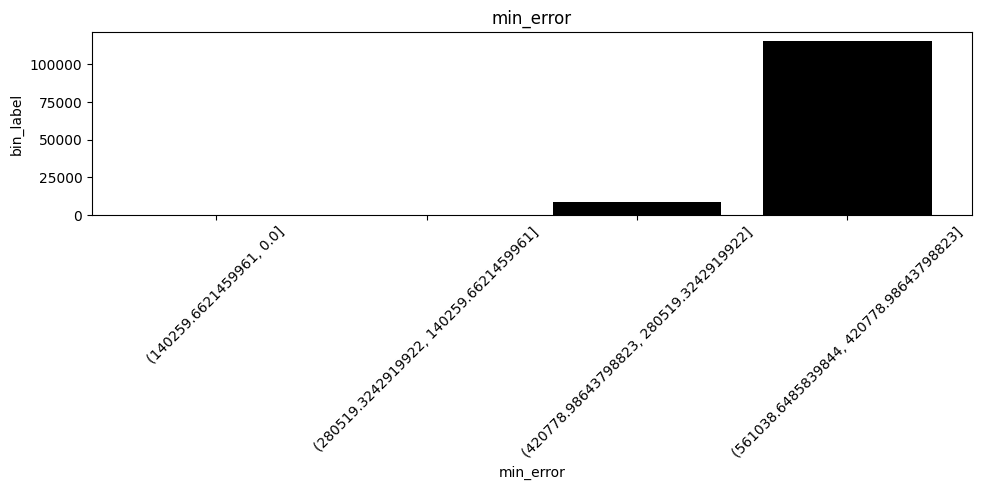

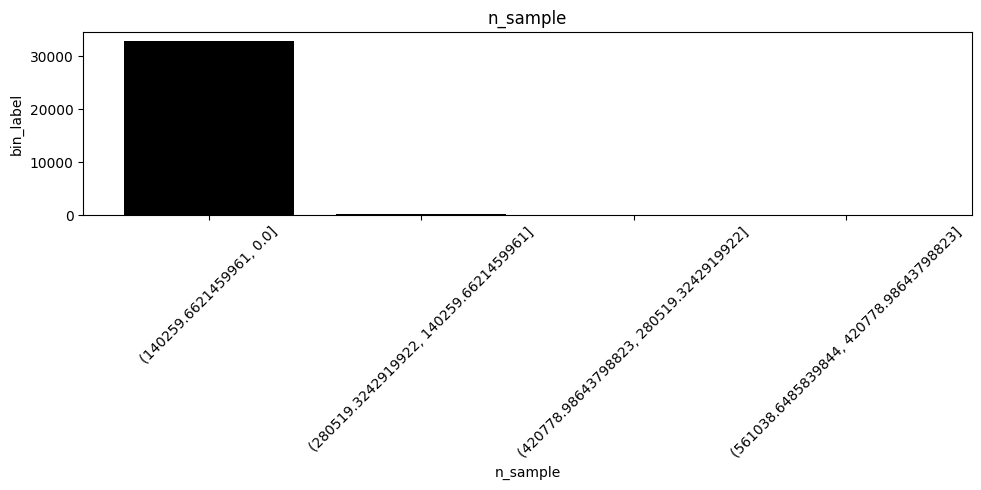

,bin_label,mean,variance,std_dev,max_error,min_error,n_sample
0,"(140259.6621459961, 0.0]",2357.280762,1.038404e+07,3222.427734,135062.43750,0.048828,32870
1,"(280519.3242919922, 140259.6621459961]",28427.482422,2.067451e+09,45469.226562,461798.31250,92.093750,138
2,"(420778.98643798823, 280519.3242919922]",55247.148438,1.677519e+09,40957.531250,143780.90625,8748.250000,17
3,"(561038.6485839844, 420778.98643798823]",161203.968750,2.081569e+09,45624.218750,206828.18750,115579.750000,2


In [18]:
predicted_prices = model.predict([test_data, test_km])

# Assuming test_prices is a 1D array, we can convert it to a DataFrame
results_df = pd.DataFrame({
    'Actual_Price': price_scaler.inverse_transform(np.array(test_prices).reshape(-1,1)).flatten(),
    'Predicted_Price': price_scaler.inverse_transform(predicted_prices).flatten(),  # Flatten in case it's a 2D array
    'km' : km_scaler.inverse_transform(test_km.to_numpy().reshape(-1, 1)).flatten()
})

# Display the first few rows of the DataFrame
print(results_df.head())

Evaluator.eval_regression(results_df["Predicted_Price"], results_df["Actual_Price"], plot=True, bins=5)